# Unlocking Network Depth: ResNet Architecture

You have already built a solid foundation in creating and training models that are often linear, with data flowing sequentially through a stack of layers. But what happens when this straightforward approach isn't enough? A logical assumption is that making a network deeper should improve its performance; however, in practice, a frustrating problem often emerges. As networks get very deep, their performance can stagnate or even worsen. This is frequently due to the **vanishing gradient problem**, where the learning signal that guides the model's updates becomes progressively weaker as it travels backward through many layers, hindering the entire network's ability to learn.

The solution lies not in a complex new algorithm, but in an elegant architectural design that gives you direct control over the flow of data. In this lab, you will see this principle in action by building and comparing two distinct deep learning models. This hands-on experiment will provide a clear, intuitive understanding of how a simple architectural change can overcome a fundamental training obstacle, enabling the creation of deeper, more powerful models.

In this lab, you will:

* Build a `PlainCNN`, a standard sequential model that will serve as a performance baseline.

* Implement a `SimpleResNet`, an advanced architecture that introduces **residual "skip" connections**.

* Train both models on the **Skyview Multi-Landscape Aerial Imagery Dataset** to classify different types of landscapes.

* Compare the performance of the two models to directly observe the impact of the skip connection on training stability and final accuracy.

Let's get started!

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
from torchvision import transforms

import helper_utils

# Set seed
SEED = 42

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## A Birds Eye View: The Skyview Dataset

Imagine you are building an automated system to map an entire region from the sky. Before you can track urban growth or monitor environmental shifts, your system needs a fundamental skill: the ability to look at an aerial image and instantly recognize what it sees. Is it a dense forest, a bustling harbor, or a sprawling residential area? This is precisely the challenge you will tackle.

For this lab, you will work with the [Skyview Multi-Landscape Aerial Imagery Dataset](https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset), a collection of **12,000 satellite images**, each of **256x256 pixels**. You are to train a model that can accurately classify these images into **15 distinct categories**. The dataset is rich and varied, featuring everything from natural landscapes like `Forest`, `River` and `Mountain` to man made structures such as `Airport`, `Highway`, and `Residential` zones.

Developing a robust landscape classifier is an essential step in many real world geospatial applications. The model you build could serve as the core component for urban planning tools, automated environmental monitoring systems, or even logistics and supply chain optimization. You are not just sorting pictures; you are teaching a machine to interpret the world, a foundational capability for countless advanced AI solutions.

* Run the next cells below to see an overview of this dataset.

In [3]:
# Set the path to the root directory of the image dataset.
dataset_path = "./Aerial_Landscapes/"

In [4]:
# Display the image count statistics for each class.
helper_utils.display_dataset_stats(dataset_path)

Class Name,Number of Images
Agriculture,800
Airport,800
Beach,800
City,800
Desert,800
Forest,800
Grassland,800
Highway,800
Lake,800
Mountain,800


### Assemble Your Data Pipeline

* First, define your pipelines of transformations for training and validation data
    * Use the pre-calculated `mean` and `std` of this dataset.

In [5]:
# Pre-calculated mean and std of this dataset
mean = [0.378, 0.393, 0.345]
std = [0.205, 0.173, 0.170]

# Transformations for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(100, 100), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Transformations for validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std,
    ),
])

* Now, you will split the data into an 80% training set and a 20% validation set.

In [6]:
# Create the training and validation datasets by splitting the main dataset.
train_dataset, val_dataset = helper_utils.create_datasets(
    dataset_path, 
    train_transform,
    val_transform,
    train_split=0.8,
    seed=SEED
)

# Determine the number of unique classes from the dataset's properties.
num_classes = len(train_dataset.classes)

# Print a summary of the dataset split.
print(f"Total Number of Classes:  {num_classes}")     
print(f"Training set size:        {len(train_dataset)}")
print(f"Validation set size:      {len(val_dataset)}")

Total Number of Classes:  15
Training set size:        9600
Validation set size:      2400


<br>

* Next, you will create the dataloaders for your training and validation sets, defining a batch size of 32.

In [7]:
# Define the number of images to process in each batch.
batch_size = 32

# Create the training and validation DataLoaders using the helper function.
train_loader, val_loader = helper_utils.create_dataloaders(train_dataset, val_dataset, batch_size)

### Visualize Training Samples

* Run the next cell to visualize your training samples.

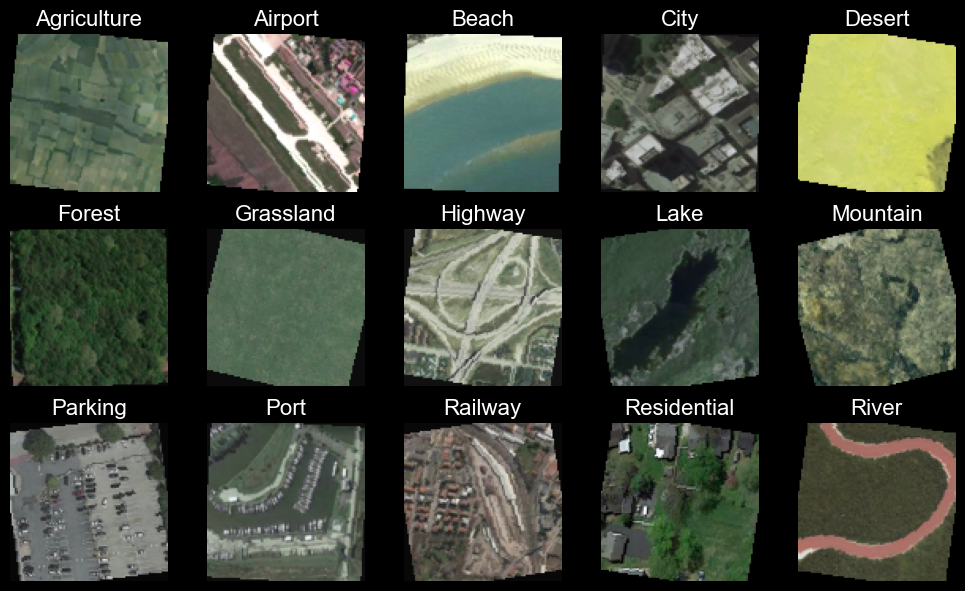

In [8]:
# Display the sample images from train set
helper_utils.show_sample_images(train_dataset)

## Architecting Your Neural Networks

You've prepared the data, and now it's time to construct the engine that will learn to classify it. In this section, you will build two distinct deep learning models from scratch. This hands on comparison is designed to give you a clear and intuitive understanding of a pivotal innovation in neural network design.

A logical assumption in deep learning is that making a network deeper by adding more layers should always improve its performance. However, in practice, a frustrating problem often emerges: as networks get very deep, their performance can stagnate or even get worse. This is often due to the **vanishing gradient problem**, where the learning signal that guides the model's updates becomes progressively weaker as it travels backward through the layers. The earliest layers end up learning very little, hindering the entire network.

How do you solve this? The answer lies not in a complex new algorithm, but in a simple, brilliant architectural design. You are about to implement this solution and see firsthand how it enables the creation of deeper, more powerful models. This is the kind of engineering insight that separates standard models from state of the art ones in professional applications, from medical imaging to the geospatial analysis you are performing now.

### The `PlainCNN`: A Baseline for Comparison

First, you will build the **baseline model**. The architecture will likely look familiar, as it follows the standard and intuitive approach of stacking convolutional blocks **sequentially**. Each block hands off its output to the next, allowing the network to learn progressively more abstract features.

This `PlainCNN` will serve as the control in your experiment. Its performance is the benchmark you will use to truly appreciate the architectural improvements of the **ResNet style model** you will build next.

#### The Core Component: A Plain Block

The `PlainBlock` is the simple, repeatable building unit for your `PlainCNN`.

* **`__init__`**: This is the constructor where you define the block's layers. It initializes two **convolutional layers** and their corresponding **batch normalization** layers, which will make up the block's architecture.

* **`forward`**: This method defines the data's path through the block. It passes the input through the first convolution and activation, then through the second, executing the layers in a **simple, sequential order**.

In [11]:
class PlainBlock(nn.Module):
    """
    A basic two-layer convolutional block without skip connections.

    Args:
        in_channels (int): The number of channels in the input feature map.
        out_channels (int): The number of channels produced by the convolutions.
        stride (int, optional): The stride for the first convolutional layer,
                                used for downsampling. Defaults to 1.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        # Initialize the parent nn.Module.
        super(PlainBlock, self).__init__()

        # First convolutional layer, which handles input channels and potential downsampling.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        """
        Defines the forward pass for the PlainBlock.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after two convolutions.
        """
        # Apply the first convolution, batch normalization, and ReLU activation.
        out = self.bn1(self.conv1(x))
        out = F.relu(out)
        
        # Apply the second convolution and batch normalization.
        # Note: A final activation is typically applied after this block in the main network.
        out = self.bn2(self.conv2(out))
        
        # Return the output feature map.
        return out

#### Constructing the `PlainCNN` Architecture

Now you'll use the `PlainBlock` as a blueprint to construct the complete `PlainCNN` model.

* **`__init__`**: This constructor builds the **full network blueprint**. It defines the initial layer, uses a helper method to stack your `PlainBlocks` into three main stages, and adds the final classification head.

* **`forward`**: This method defines the **end to end data flow**. It passes an image tensor through each stage of the network in order, from the initial convolution to the final prediction layer.

In [12]:
class PlainCNN(nn.Module):
    """
    A plain Convolutional Neural Network for image classification.

    This network is constructed from a series of basic convolutional blocks
    (PlainBlock) without using residual (skip) connections. It features an
    initial convolution, followed by several layers of stacked blocks that
    progressively increase channel depth and reduce spatial dimensions, and
    concludes with a classification head.

    Args:
        num_classes (int, optional): The number of output classes for the final
                                     classification layer. Defaults to 5.
        num_blocks (list of int, optional): A list defining the number of
                                            PlainBlocks in each of the three
                                            main layers. Defaults to [2, 2, 2].
    """
    def __init__(self, num_classes=5, num_blocks=[2, 2, 2]):
        # Initialize the parent nn.Module.
        super(PlainCNN, self).__init__()

        # Initialize the number of input channels for the first main layer.
        self.in_channels = 32
        
        # Initial convolutional block to process the input image.
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Define the main layers of the network by stacking PlainBlocks.
        self.layer1 = self._make_layer(32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, num_blocks[2], stride=2)

        # Final block for global average pooling and classification.
        self.final_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes),
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        """
        Builds a layer by stacking multiple PlainBlocks.

        Args:
            out_channels (int): The number of output channels for the blocks.
            num_blocks (int): The number of blocks to stack in this layer.
            stride (int): The stride for the first block, used for downsampling.

        Returns:
            nn.Sequential: A sequential container of the stacked blocks.
        """
        # Initialize an empty list to hold the blocks for this layer.
        layers = []
        
        # The first block in a layer handles downsampling and channel changes.
        layers.append(PlainBlock(self.in_channels, out_channels, stride))
        
        # Update the number of input channels for the subsequent layer.
        self.in_channels = out_channels
        
        # Add the remaining blocks for this layer.
        for _ in range(1, num_blocks):
            layers.append(PlainBlock(self.in_channels, out_channels))
            
        # Return the blocks wrapped in a sequential container.
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Defines the forward pass for the PlainCNN.

        Args:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output logits from the final classification layer.
        """
        # Pass the input through the initial block.
        out = self.initial_block(x)
        
        # Pass through the main layers, each followed by a ReLU activation.
        out = F.relu(self.layer1(out))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        
        # Pass through the final classification block.
        out = self.final_block(out)
        
        # Return the final output logits.
        return out

### The `SimpleResNet`: An Elegant Solution

Now for the main event. You'll build a model using the ResNet style of architecture. On the surface, it looks very similar to the `PlainCNN`, but it contains one pivotal change that makes all the difference.

Instead of a `PlainBlock`, you'll use a `ResidualBlock`. This block introduces a **"skip connection"** or **"shortcut"** that runs in parallel to the main convolutional layers. This simple addition is the elegant solution to the vanishing gradient problem. It creates an express lane for the learning signal to travel back through the network, ensuring that even the earliest layers get strong, clear updates. By adding the original input back at the end of the block, you're also reframing the learning task: the network now only needs to learn the *residual*, or the change from the input, which is often much easier.

#### The Key Innovation: A Residual Block

This block is the advanced building unit that gives your ResNet style model its power.

* **`__init__`**: 
> This is the constructor where the block's components are defined.
>    * Like the `PlainBlock`, it sets up two main **convolutional steps**.
>    * Unlike the `PlainBlock`, it includes a `downsample` parameter. This is a special, optional layer whose only job is to resize the input on the **skip connection path** if its dimensions change, ensuring the two paths can be added together.

* **`_initial_forward`**: 
> This helper method defines the **main transformation path**.
>    * This path is functionally identical to the *entire* `forward` pass of the `PlainBlock`. Think of this as the **"scenic route"** where the detailed feature extraction happens.

* **`forward`**: 
> This is the main event where the block's signature logic happens. The operations here are the **exact code additions that create the skip connection** and are completely absent in the `PlainBlock`:
>    1.  **Save the Input (`identity = x`)**: The very first step is to create a copy of the original, untouched input. This establishes the "express lane" or shortcut path. 
>    2.  **Transform the Input (`out = _initial_forward(x)`)**: The input is also sent down the "scenic route" for transformation.
>    3.  **Merge the Paths (`out += identity`)**: This is the pivotal moment. The transformed output (`out`) is merged with the original `identity` via addition. 
>        * This step, adding the original input back, is the defining operation of a residual connection.
>    4.  **Final Activation (`F.relu(out`))**: The activation function is applied only *after* the two paths have been combined.

In [ ]:
class ResidualBlock(nn.Module):
    """
    A fundamental building block for ResNet architectures.

    This block implements a residual connection, allowing the network to learn
    an identity function if needed. It consists of a main path with two
    convolutional layers and a "skip connection" that adds the input of the
    block to its output. This helps mitigate the vanishing gradient problem in
    very deep networks.

    Args:
        in_channels (int): The number of channels in the input tensor.
        out_channels (int): The number of channels produced by the convolutions.
        stride (int, optional): The stride for the first convolutional layer,
                                used for downsampling. Defaults to 1.
        downsample (nn.Module, optional): A module to downsample the input
                                          (identity) so its dimensions match the
                                          output for the skip connection.
                                          Defaults to None.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        # Initialize the parent nn.Module.
        super(ResidualBlock, self).__init__()

        # First component of the main path: Conv -> BatchNorm -> ReLU.
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        # Second component of the main path: Conv -> BatchNorm.
        # Note: The final ReLU is applied after the skip connection.
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
        )

        # Optional downsampling layer for the skip connection.
        self.downsample = downsample

    def _initial_forward(self, x):
        """Defines the main convolutional path of the block."""
        out = self.conv_block_1(x)
        out = self.conv_block_2(out)
        return out

    def forward(self, x):
        """
        Defines the forward pass, combining the main path and the skip connection.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor of the residual block.
        """
        # Store the input for the skip connection.
        identity = x

        # Pass the input through the main convolutional path.
        out = self._initial_forward(x)

        # If needed, apply downsampling to the identity to match dimensions.
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the original input (identity) to the output of the main path.
        out += identity

        # Apply the final activation function.
        out = F.relu(out)

        # Return the final output of the block.
        return out

#### Assembling the `SimpleResNet` Architecture

The `SimpleResNet` class assembles the `ResidualBlocks` into a full network. While its blueprint is nearly identical to the `PlainCNN` to ensure a fair comparison, the internal mechanics are significantly different and more powerful.

* **`__init__`**: 
> This method lays out the network's blueprint.  
>    * Its structure is **intentionally identical** to the `PlainCNN`'s constructor to ensure a fair comparison.
>    * It begins the process of **setting up the skip connection** by calling the `_make_residual_block` helper.

* **`_get_initial_block` & `_get_final_block`**: 
> These helpers create the network's standard entry and exit points (the "stem" and "head").  
>    * The layers they produce are **100% identical** to the start and end blocks of the `PlainCNN`.
>    * They are standard components and play **no role** in the skip connection logic.

* **`_make_residual_block`**: 
> This is the advanced counterpart to the `PlainCNN`'s simple `_make_layer` method, and its main job is to **configure the skip connection** for an entire stage.
>    * It intelligently checks if the image dimensions or channels are changing.
>    * If so, it creates a `downsample` layer and passes it to the *first* `ResidualBlock` of that stage.
>    * This configuration logic is completely absent in the `PlainCNN`.

* **`forward`**: 
> Defines the end-to-end data flow through the network.
>    * A key difference from `PlainCNN.forward` is that this function **lacks explicit `F.relu` calls** between stages.
>    * This is because the skip connection is **executed** within each `ResidualBlock` that is called from here. The actual `out += identity` merge and subsequent `ReLU` happen *inside* the blocks themselves.

In [ ]:
class SimpleResNet(nn.Module):
    """
    A simplified ResNet-style architecture for image classification.

    This network is built by stacking ResidualBlock modules. It consists of an
    initial convolutional layer, followed by three main stages of residual
    blocks, and a final classification head with global average pooling.

    Args:
        num_classes (int, optional): The number of output classes for the final
                                     classification layer. Defaults to 5.
        num_blocks (list of int, optional): A list defining the number of
                                            ResidualBlocks in each of the three
                                            main stages. Defaults to [2, 2, 2].
    """
    def __init__(self, num_classes=5, num_blocks=[2, 2, 2]):
        # Initialize the parent nn.Module.
        super(SimpleResNet, self).__init__()

        # Store the number of classes for the final layer.
        self.num_classes = num_classes
        
        # Initialize the number of input channels for the first residual stage.
        self.in_channels = 32

        # Define the initial convolutional layer.
        self.initial_block = self._get_initial_block()

        # Construct the main stages of the network using residual blocks.
        self.res_block1 = self._make_residual_block(32, num_blocks[0], stride=1)
        self.res_block2 = self._make_residual_block(64, num_blocks[1], stride=2)
        self.res_block3 = self._make_residual_block(128, num_blocks[2], stride=2)

        # Define the final classification head.
        self.final_block = self._get_final_block()

    def _make_residual_block(self, out_channels, num_blocks, stride):
        """
        Builds a residual stage by stacking multiple ResidualBlocks.

        Args:
            out_channels (int): The number of output channels for the blocks.
            num_blocks (int): The number of blocks to stack in this stage.
            stride (int): The stride for the first block, used for downsampling.

        Returns:
            nn.Sequential: A sequential container of the stacked blocks.
        """
        # Initialize the downsample layer as None.
        downsample = None
        
        # Define the downsample layer if stride is not 1 or if channel dimensions change.
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )

        # Initialize a list to hold the layers for this stage.
        layers = []
        
        # The first block in a stage handles downsampling and channel changes.
        first_block = ResidualBlock(self.in_channels, out_channels, stride, downsample)
        layers.append(first_block)
        
        # Update the number of input channels for the subsequent stage.
        self.in_channels = out_channels

        # Add the remaining residual blocks for this stage.
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        # Return the blocks wrapped in a sequential container.
        return nn.Sequential(*layers)

    def _get_initial_block(self):
        """Constructs the initial convolutional layer of the network."""
        initial_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        return initial_block

    def _get_final_block(self):
        """Constructs the final classification head of the network."""
        final_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.num_classes),
        )
        return final_block

    def forward(self, x):
        """
        Defines the forward pass for the SimpleResNet.

        Args:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output logits from the final classification layer.
        """
        # Pass input through the initial convolutional block.
        out = self.initial_block(x)
        
        # Pass through the three main stages of residual blocks.
        out = self.res_block1(out)
        out = self.res_block2(out)
        out = self.res_block3(out)
        
        # Pass through the final classification head.
        out = self.final_block(out)
        
        # Return the final output logits.
        return out

### Initialize the Models

With your architectural blueprints complete, it's time to construct your two competitors.

* Create instances of both, the `SimpleResNet` and the `PlainCNN` models, preparing them for the training process.
    * `PlainCNN` will serve as the baseline control in your experiment. You'll use its performance as a benchmark to see just how much of an improvement the skip connections in `SimpleResNet` really provide.

In [ ]:
# Set the random seed to ensure that both models are always initialized with the same random weights.
torch.manual_seed(SEED)

# Create an instance of the SimpleResNet model.
resnet_model = SimpleResNet(num_classes=num_classes)

# Create an instance of the PlainCNN model for your baseline comparison.
plain_model = PlainCNN(num_classes=num_classes)

### Examining the Model Architecture

Before you start the resource-intensive process of training, a professional workflow includes a critical quality check: **examining the model's architecture**. Think of this as an architect reviewing the final blueprints before construction begins. It allows you to verify that every component is connected correctly and to understand the true complexity of what you've built.

In a real-world project, this step is essential. It helps you catch errors early, estimate computational costs, and plan for deployment. You'll use the [torchinfo](https://github.com/TylerYep/torchinfo) library to generate this blueprint, which provides a layer-by-layer breakdown with vital details:

* **Output Shape Flow**: You can trace the journey of your data, seeing how its dimensions change at each layer. This is invaluable for debugging common dimension mismatch errors before you even start training.

* **Parameter Count**: The summary reveals the number of trainable parameters in each layer and in total. This number directly impacts your choice of hardware, your training time, and the model's final deployment size. A model with 10 million parameters has very different requirements than one with 100 million.

This step ensures your model is built as intended and gives you a clear picture of its computational profile before you commit to training.

* Call the `torchinfo.summary` function, the main command that inspects your model and generates the architectural summary based on these arguments:
    * `model=resnet_model`: The PyTorch model you want to analyze.
    * `input_size=...`: This specifies the **shape of a sample input tensor** (batch size, channels, height, width).
        * `torchinfo` performs a "dry run" with this shape to calculate the output size of each layer.
    * `col_names=...`: This lets you customize **which columns** of information to display in the summary.
    *  `depth=...`: This controls **how many levels deep** the summary should go into your nested modules (like `ResidualBlock`).
* The `display_torch_summary` helper function takes this summary object and prints it as a clean, easy to read table.

In [ ]:
# Define a configuration dictionary to store parameters for the model summary.
config = {
    "input_size": (batch_size, 3, 64, 64),
    "attr_names": ["input_size", "output_size", "num_params", "trainable"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #", "Trainable"],
    "depth": 3
}

# Generate the model summary object using torchinfo with the specified configuration.
summary = torchinfo.summary(
    model=resnet_model, 
    input_size=config["input_size"], 
    col_names=config["attr_names"], 
    depth=config["depth"]
)

# Display the summary as a styled HTML table.
print("--- Model Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

<br>

This summary, with a `depth=3`, is the proof that your architecture is correctly wired. By tracing the **Input Shape** and **Output Shape** columns, you can confirm your design logic is working exactly as intended.

A key verification point is observing when the `downsample` layer appears within the first `ResidualBlock` of each stage:

* **Stage 1 (`Sequential: 1-2`)**: Notice the input and output shapes are identical (`[...32, 64, 64]`). As expected, there's no `downsample` layer because neither the dimensions nor the channels change. The skip connection can be a direct identity copy.

* **Stages 2 & 3 (`Sequential: 1-3` & `1-4`)**: Here you see the shapes change dramatically (e.g., from `[...32, 64, 64]` to `[...64, 32, 32]`). This confirms that the `downsample` layer has been correctly added inside the first `ResidualBlock` of these stages.

This happens for two reasons: the number of **channels doubles**, and the **spatial dimensions are halved** (due to `stride=2`). The summary confirms that your `_make_residual_block` method correctly identified this change and added the `downsample` layer to make the skip connection possible. Your blueprint has been built to spec!

## Launching the Experiment: The Training Phase
Your two models, the `PlainCNN` and the `SimpleResNet`, are now fully constructed and waiting at the starting line. Before the race can begin, you need to define two final components for the training process.

### Loss Function and Optimizers

* Define the loss function and optimizers that will drive the training process.
    * You'll use the same loss function for both models, but you will create a separate optimizer for each one. This is necessary to track and update the weights for the `PlainCNN` and `SimpleResNet` models independently.

In [ ]:
# Use CrossEntropyLoss, a standard loss function for multi-class classification tasks.
loss_function = nn.CrossEntropyLoss()

# Create an Adam optimizer to update the weights of the ResNet model.
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# Create a separate Adam optimizer for the Plain CNN model to train it independently.
optimizer_plain = optim.Adam(plain_model.parameters(), lr=0.001)

### Training and Validation

You will now train both of your models using the provided `training_loop_16_mixed` training function. This custom loop handles the complete training and validation cycle, and it uses a **16 bit mixed precision strategy** to accelerate performance. This optimization is implemented using **PyTorch's own built in libraries**.

To judge the performance of the models fairly, the function will track and return the following key results for later comparison:

* `history`: A Python dictionary that records the performance after each epoch. It contains the **training loss**, **validation loss**, and **validation accuracy**, which are essential for plotting the learning curves to visualize the training progress.

* `final_cm`: A confusion matrix calculated on the validation data after the final epoch. This is a powerful tool that shows exactly which classes the model is confusing with others, helping you analyze its specific strengths and weaknesses.

* Feel free to set a different value for `num_epochs`. It's currently set to **10**, which is a good starting point and sufficient to get a meaningful performance comparison for these experiments.

In [ ]:
# Define the total number of full training cycles (epochs) to run.
num_epochs = 10

* First up is your baseline model. Send the `PlainCNN` through the training loop to see how it performs.

In [ ]:
# Training of `plain_model`
trained_plain, history_plain, cm_plain = helper_utils.training_loop_16_mixed(
    model=plain_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer_plain,
    num_epochs=num_epochs,
    device=device
)

* With the baseline set, it's time for your advanced `SimpleResNet`. Run it through the same training process and see if the skip connections give it an edge.

In [ ]:
# Training of `resnet_model`
trained_resnet, history_resnet, cm_resnet = helper_utils.training_loop_16_mixed(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer_resnet,
    num_epochs=num_epochs,
    device=device
)

### The Tale of the Tape: Visualizing Performance

With both models trained, it's time to see which one performed better. You'll now plot the learning curves from both history objects of the trained models.

This will give you a direct, visual comparison of how the `PlainCNN` (your baseline) and the `SimpleResNet` (your advanced model) performed on key metrics like **loss** and **accuracy** throughout the training process.

In [ ]:
# Plot the training metrics from both models for a direct visual comparison.
helper_utils.plot_training_logs(history_plain, history_resnet)

<br>

The plots clearly illustrate the powerful advantage of the ResNet style architecture. While exact numbers can vary slightly with different number of epochs, the trends you see here are a classic demonstration of why skip connections are so effective.

* **Training and Validation Loss**: The `SimpleResNet` model (blue lines) consistently achieves a **lower and more stable loss** on both the training and validation sets. In contrast, the `PlainCNN` (red lines) struggles to keep its validation loss consistently decreasing, a common sign that a deep network is having a harder time optimizing and generalizing to new data.

* **Validation Accuracy**: The accuracy graph tells an even clearer story. The `SimpleResNet` model not only reaches a **significantly higher final accuracy** (around 79% in this run), but its learning curve is also much smoother and more consistent. The `PlainCNN` improves, but its progress is more erratic and it plateaus at a lower performance level (around 67%).

These results strongly indicate that the **residual connections** are the key difference maker. By providing a "shortcut" for the gradient to flow through the network, they help prevent the vanishing gradient problem. This allows the ResNet style model to learn more effectively from the data, leading to the more stable learning, lower loss, and higher final accuracy you see here.

## Visualizing Predictions and Confusion Matrices

The learning curves gave you a high level view of the performance, but seeing your model's predictions on individual images is a great way to move beyond aggregate scores and get a true qualitative feel of it. This is where you can see **what** your model gets right and, more importantly, *where* it might be making mistakes. 

* First, you'll visualize a batch of predictions from your superior `SimpleResNet` model to see how it performs on different landscape types.

In [ ]:
# Get the list of class names (e.g., 'Forest', 'River') from the dataset for plotting.
class_names = val_loader.dataset.classes

# Visualize predictions from the SimpleResNet model on the validation data.
helper_utils.visualize_predictions(trained_resnet, val_loader, class_names, device)

In [ ]:
# ### Uncomment and execute the line below if you wish to see the predictions by the trained PlainCNN model.

# # Visualize predictions from the PlainCNN model on the validation data.
# helper_utils.visualize_predictions(trained_plain, val_loader, class_names, device)

<br>

Visualizing individual predictions gives you a good gut feeling for the model's performance, but now it's time for a more detailed analysis. A single overall accuracy score can be misleading. To truly understand the impact of the skip connections, you need a more nuanced story that reveals where the ResNet style architecture excels. 

* First, generate per class accuracy and a confusion matrix for the trained `PlainCNN` model.

In [ ]:
# Plot the confusion matrix for the baseline PlainCNN to analyze its error patterns.
helper_utils.plot_confusion_matrix(cm_plain, class_names)

<br>

* Now, generate per class accuracy and a confusion matrix for the trained `SimpleResNet` model.

In [ ]:
# Plot the confusion matrix for the ResNet style model to analyze its error patterns.
helper_utils.plot_confusion_matrix(cm_resnet, class_names)

<br>

**The Clear Advantage of Skip Connections**

The most significant trend is the **dramatic performance increase** for the ResNet style model on classes defined by complex details, fine lines, or intricate patterns.

* **Learning Fine Grained Features**: The baseline `PlainCNN` often struggles with categories like `Airport`, `Highway`, and `River`. This is likely because as the data passes through many sequential layers, the critical information about these fine linear features gets diluted, a classic symptom of a network struggling with information flow. The ResNet style model, however, excels on these classes. Its **skip connections** act as an "information highway," preserving these crucial details and allowing the model to learn the complex patterns more effectively.

* **Recognizing Dense Structures**: Similarly, for classes like `Residential` areas and `Parking` lots, the ResNet style model shows a major improvement. Its ability to maintain a strong gradient signal helps it distinguish between the densely packed, repeating objects in these images.

## Conclusion

This experiment has clearly demonstrated the powerful advantage of a well-designed custom architecture. While both the `PlainCNN` and the `SimpleResNet` were built with the same number of layers, the `SimpleResNet` achieved significantly better performance, showcasing more stable training and higher final accuracy. This outcome is a direct result of its core architectural feature: the **residual connection**.

The `PlainCNN`, with its purely sequential design, likely struggled with the vanishing gradient problem, where the learning signal faded as it propagated backward through the network's depth. In contrast, the `SimpleResNet`'s skip connections created a direct "express lane" for the gradient. By adding the original input back to the transformed output (`out += identity`), the network preserves the gradient signal, ensuring that even the earliest layers receive strong updates and continue to learn effectively.

You've seen firsthand that building state-of-the-art models is about more than just stacking layers. It's about understanding the challenges that arise during training and engineering intelligent solutions directly into the model's architecture. By implementing the residual block, you've moved beyond a simple linear data flow and taken direct control, proving how a simple, elegant idea can solve a complex problem and unlock the potential of deep neural networks.